In [1]:
import numpy as np
from util_functions import normalize, plot_agents, plot_mdp
import matplotlib.pyplot as plt
from tqdm import trange

# TestEnv
There are two states which represent the cooperation status at last state: `COOP` and `BETRAY`. Only if two agents both cooperate at last stage, then next state will be `COOP`, otherwise will be `BETRAY`. Note that the row's actions are for agent label in the table. The state will increase the utility of choosing that state action.

Specifically, at state `COOP`, the utility function for agents are:  
| agent 1 $\rightarrow$ | cooperate | betray |  | agent 2 $\rightarrow$ | cooperate | betray |
|---|---|---|---|---|---|---|
|cooperatre| 2 | +4 | | cooperate | 2 | +4 |
|betray | -4 | -2 | | betray | -4 | -2 |

At state `BETRAY`, the utility function for agents are:
| agent 1 $\rightarrow$ | cooperate | betray | | agent 2 $\rightarrow$ | cooperate | betray | 
|---|---|---|---|---|---|---|
|cooperatre| +2 | 4 | | cooperate | +2 | 4 |
|betray | -4 | -2 | | betray | -4 | -2 | 

We denote each matrix as $U_C^{1}$, $U_C^{2}$ as utility matrix at state `COOP` for agent 1 and agent 2 respectively. And denote $U_B^{1}$, $U_B^{2}$ as utility matrix at state `BETRAY` for agent 1 and agent 2 respectively. 


In [2]:
utility_coop_a1 = np.array([ [2,4],[-4,-2] ])
utility_coop_a2 = np.array([ [2,4],[-4,-2] ])
utility_betray_a1 = np.array([ [2,4],[-4,-2] ])
utility_betray_a2 = np.array([ [2,4],[-4,-2] ])

To make the strategies of agents not pure strategies, we add entropy term. Assume we denote
$$a^i_C\in\Delta(\{cooperate, betray\})=:\Delta(2)$$
as the strategy agent $i$ take in state `COOP`, then we have: 
$$ u^1_C(a^1_C, a^2_C) = (a_C^2)^\top U_C^1 a^1_C - \lambda (a^1_C)^\top \log(a^1_C) + ([\theta^1_C,0])^\top a^1_C \\
u^2_C(a^1_C, a^2_C) = (a_C^1)^\top U_C^2 a^2_C - \lambda (a^2_C)^\top \log(a^2_C) + ([\theta^2_C,0])^\top a^2_C\\
u^1_B(a^1_B, a^2_B) = (a_B^2)^\top U_B^1 a^1_B - \lambda (a^1_B)^\top \log(a^1_B) + ([\theta^1_B,0])^\top a^1_B\\
u^2_B(a^1_B, a^2_B) = (a_B^1)^\top U_B^2 a^B_C - \lambda (a^2_B)^\top \log(a^2_B) + ([\theta^2_B,0])^\top a^2_B $$
where $\lambda$ is the temperature variable, and $\theta_C^1\in\mathbb{R}$ is the incentive provided to agent 1 for taking cooperate action, and other $\theta^2_C, \theta^1_B$ have corresponding meaning. Note that incentive will only apply to the 'cooperation' action, thus the incentive vector is $[\theta^1_C, 0]$, $[\theta^2_C, 0]$ at state `COOP`, and $[\theta^1_B, 0]$, $[\theta^1_B, 0]$ at state `BETRAY`. 

We assume that agents use mirror ascent to update their strategies to find the Nash equilirium, therefore we have: 
$$ 
\begin{align*}
u^1_{C,k+1} &\leftarrow \mathop{\argmax}_{a^1_C\in\Delta(2)} \left\{  \nabla_{a^1_C}u^1_C(a^1_{C,k}, a^2_{C,k})^\top (a^1_C-a^1_{C,k}) - \frac{1}{\alpha_k} D_{KL}(a^1_C, a^1_{C,k})  \right\}
\end{align*}
$$
and $\alpha_k$ is pre-defined step size and $D_{KL}(a^1_C, a^1_{C,k}):=(a^1_C)^\top \log(a^1_C / a^1_{C,k}) $. Under this setting, the update rule has closed-form solution by the first-order optimality condition of above optimization problem. 
$$
a^1_{C,k+1} \propto a^1_{C,k} * \exp(\alpha_k \nabla_{a^1_C}u^1_C(a^1_{C,k}, a^2_{C,k}))
$$
where $*$ is element-wise multiplication. Note that this make sense if we get rid of the entropy term, then the gradient for agent 1 is $(a_C^2)^\top U_C^1 + \theta_C^1$ which is exactly the utility of choosing each action. Therefore the gradient is actually the ‘marginal influence’ of actions for agent 1. （Note sure whether this is correct. ）

In [3]:
def update_strategies(s, a1, a2, i1, i2, lamda, alpha):
    """ Update strategies once """
    if s == 0:  # COOP
        u1 = utility_coop_a1
        u2 = utility_coop_a2
    elif s == 1:    # BETRAY
        u1 = utility_betray_a1
        u2 = utility_betray_a2
    
    # Calculate strategy before normalization
    a1_ = a1 * np.exp( alpha * (a2.T @ u1 + i1 - lamda * np.ones(2) - lamda * np.log(a1)) )
    a2_ = a2 * np.exp( alpha * (a1.T @ u2 + i2 - lamda * np.ones(2) - lamda * np.log(a2)) )

    # Normalize
    a1_normalized = normalize(a1_)
    a2_normalized = normalize(a2_)

    return a1_normalized, a2_normalized

For example, we can try with incentive begin both zero, and $\lambda$ be 0.1. The result could be calculated by a while loop.

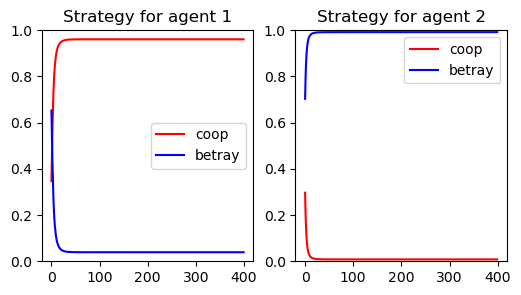

In [24]:
T = 400
init_a1 = normalize( np.random.uniform(0,1,2) )
init_a2 = normalize( np.random.uniform(0,1,2) )
# init_a1 = np.array( [0.85, 0.15] )
# init_a2 = np.array( [0.2, 0.8] )
i1 = np.array([10.0,0])  # PLEASE change here the incentive
i2 = np.array([-10.0,0])

# Calculate Nash equilibrium and plot the trajectory of strategies
s = 0
lamda = 2.5
alpha = 0.05
a1_C_traj = np.zeros([T, 2])
a2_C_traj = np.zeros([T, 2])
a1 = init_a1
a2 = init_a2
cnt = 0
while cnt<T:
    a1_C_traj[cnt] = a1
    a2_C_traj[cnt] = a2
    if s==0:
        a1, a2 = update_strategies(0, a1, a2, i1, i2, lamda=lamda, alpha=alpha)
    else:
        a1, a2 = update_strategies(1, a1, a2, i1, i2, lamda=lamda, alpha=alpha)
    cnt += 1
plot_agents(T, a1_C_traj, a2_C_traj)

## Single transition tryout
We first try for the environment where only one transition occurs, i.e., the goal of incentive designer is to induce specific strategy in a repeated prisoner dillema game. The goal of the incentive designer is to induce following strategy at `COOP` state. 
$$
a^1 = [0.8, 0.2]; a^2=[0.45,0.55]
$$
Therefore, the loss function is 
$$
\ell(a^1_{C,*}(\theta), a^2_{C,*}(\theta)) := \frac{1}{2}\left(\left( a^1-a^1_{C,*}(\theta) \right)^2 + \left( a^2-a^2_{C,*}(\theta) \right)^2\right)
$$
To make the loss smaller, we calculate the gradient $\nabla_\theta \ell(a^1_{C,*}(\theta), a^2_{C,*}(\theta))$ as
$$
\begin{align*}
    \nabla_\theta \ell(a^1_{C,*}(\theta), a^2_{C,*}(\theta)) &= \left( a^1_{C,*}(\theta) - a^1 \right) \nabla_{\theta} a^1_{C,*}(\theta) + \left( a^2_{C,*}(\theta) - a^2 \right) \nabla_\theta a^2_{C,*}(\theta) \\
    & = [ a^1_{C,*}(\theta) - a^1, a^2_{C,*}(\theta) - a^2 ]^T * \nabla_\theta a_{C,*}(\theta)
\end{align*}
$$

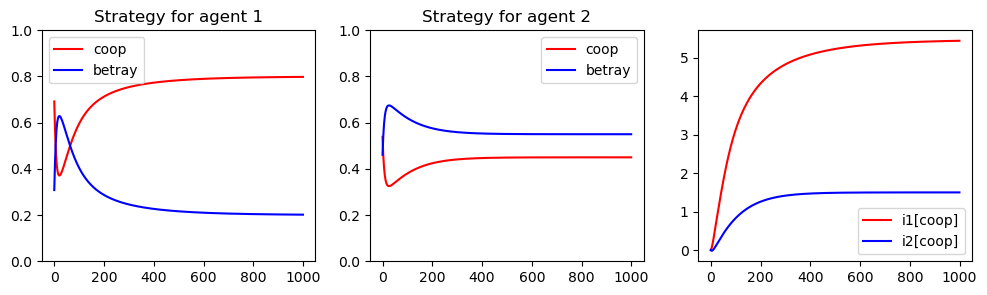

In [52]:
def get_sensetivity_mat(s, a1, a2, lamda):
    """ This function return the sensitivity matrix of current game """
    if s == 0:  # COOP
        u1 = utility_coop_a1
        u2 = utility_coop_a2
    elif s == 1:    # BETRAY
        u1 = utility_betray_a1
        u2 = utility_betray_a2

    nabla_a_F = np.vstack( [ np.hstack([-lamda*np.diag(1/a1), u1]), np.hstack([u2, -lamda*np.diag(1/a2)]) ] )
    L = np.linalg.inv(nabla_a_F)

    A = np.array([[1,1,0,0], [0,0,1,1]])    # A represents the simplex constraint, i.e., the sum of a1 and a2 should be one
    M = L-L@A.T@ np.linalg.inv(A@L@A.T) @ A@L
    nabla_y_F = np.array([[1,0,0,0], [0,0,1,0]])

    nabla_y_x = (-M @ nabla_y_F.T).T
    return nabla_y_x

T = 1000
init_a1 = normalize( np.random.uniform(0,1,2) )
init_a2 = normalize( np.random.uniform(0,1,2) )
# init_a1 = np.array( [0.5, 0.5] )
# init_a2 = np.array( [0.5, 0.5] )
init_i = np.array( [0., 0.] )
a1_target = np.array([0.8, 0.2])
a2_target = np.array([0.45, 0.55])

# Calculate Nash equilibrium and plot the trajectory of strategies
s = 0
lamda = 2.5
alpha = 0.05
beta = 5e-1
a1_C_traj = np.zeros([T, 2])
a2_C_traj = np.zeros([T, 2])
i_C_traj = np.zeros([T, 2])
a1 = init_a1
a2 = init_a2
i1 = np.array([init_i[0],0.])
i2 = np.array([init_i[1],0.])
cnt = 0

while cnt<T:
    a1_C_traj[cnt] = a1
    a2_C_traj[cnt] = a2
    i_C_traj[cnt] = [i1[0], i2[0]]

    # Update incentive
    sensitivity_mat = get_sensetivity_mat(s, a1, a2, lamda)
    update_term =  sensitivity_mat @ np.concatenate( [ a1 - a1_target, a2 - a2_target ] )
    i1[0] -= beta * update_term[0]
    i2[0] -= beta * update_term[1]
    
    # Update agent 
    if s==0:
        a1, a2 = update_strategies(0, a1, a2, i1, i2, lamda=lamda, alpha=alpha)
    else:
        a1, a2 = update_strategies(1, a1, a2, i1, i2, lamda=lamda, alpha=alpha)
    cnt += 1

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12,3])
ax1 = axs[0]
ax1.set_ylim((0,1))
ax1.plot(np.arange(T), np.array(a1_C_traj)[:, 0], label="coop", color='r')
ax1.plot(np.arange(T), np.array(a1_C_traj)[:, 1], label="betray", color='b')
ax1.set_title("Strategy for agent 1")
ax1.legend()

ax2 = axs[1]
ax2.set_ylim((0,1))
ax2.plot(np.arange(T), np.array(a2_C_traj)[:, 0], label="coop", color='r')
ax2.plot(np.arange(T), np.array(a2_C_traj)[:, 1], label="betray", color='b')
ax2.set_title("Strategy for agent 2")
ax2.legend()

ax3 = axs[2]
ax3.plot(np.arange(T), i_C_traj[:,0], label="i1[coop]", color='r')
ax3.plot(np.arange(T), i_C_traj[:,1], label="i2[coop]", color='b')
ax3.legend()

plt.show()

## MDP formulation
Now we can turn to the MDP setting. We need to sepcify transition probability and reward function. To simplify the notation, we denote $\mathbf{c}$ as action cooperate and $\mathbf{b}$ as aciton betray
The transition probability is rather easy, it is determined by agents' strategies: 
$$
\begin{align*}
P(\text{COOP|COOP}) &= a^1_C[\mathbf{c}] * a^2_C[\mathbf{c}] \\
P(\text{BETRAY|COOP}) &= a^1_C[\mathbf{c}] * a^2_C[\mathbf{b}] + a^1_C[\mathbf{b}] * a^2_C[\mathbf{c}] + a^1_C[\mathbf{b}] * a^2_C[\mathbf{b}]\\
P(\text{COOP|BETRAY}) &= a^1_B[\mathbf{c}] * a^2_B[\mathbf{c}] \\
P(\text{BETRAY|BETRAY}) &= a^1_B[\mathbf{c}] * a^2_B[\mathbf{b}] + a^1_B[\mathbf{b}] * a^2_B[\mathbf{c}] + a^1_B[\mathbf{b}] * a^2_B[\mathbf{b}]
\end{align*}
$$
We develope three modes of reward function. The first is easiest, second is harder and the third is the hardest
$$
\begin{align*}
1 \qquad &R(\text{COOP}) = 1, &R(\text{BETRAY})&=0\\
2 \qquad &R(\text{COOP}) = (a^1_C[\mathbf{c}] + a^2_C[\mathbf{c}])*2, &R(\text{BETRAY}) &= a^1_B[\mathbf{b}]+a^2_B[\mathbf{b}]\\
3 \qquad &R(\text{COOP}) = 2 - (a^1_C[\mathbf{c}]-0.7)^2 - (a^2_C[\mathbf{c}]-0.8)^2 &R(\text{BETRAY}) &= 2 - (a^1_B[\mathbf{b}]-0.6)^2 - (a^2_B[\mathbf{b}]-0.6)^2
\end{align*}
$$
The first reward type means that at state `COOP`, ID will receive +1 and at state `BETRAY` will receive 0, regardless of the action of agents. The second reward type specify that larger the probability of choosing action, larger the reward. Note that it creats a local optima in choosing higher probability of action 'betray' since this leads to higher rewrads in state `BETRAY`. The third reward type is hardest since it require delicate design of incentive to induce accurate specified strategy probability.  
We can show in other files that the agents' strategies are actaully given by the mean of incentive. Therefore, by setting the probability of choosing actions, we can achieve bonuses in between.  

In [6]:
def get_P_vec(a1_s, a2_s):
    P = np.zeros(2)
    P[0] = a1_s[0] * a2_s[0]
    P[1] = 1-P[0]
    return P

def get_P_mat(a1, a2):
    P = np.zeros([2,2])
    P[0] = get_P_vec(a1[0], a2[0])  # COOP -> [COOP, BETRAY]
    P[1] = get_P_vec(a1[1], a2[1])  # BETRAY -> [COOP, BETRAY]
    return P

## Algorithm
We focus on a deterministic incentive design problem. In this formulation, we assign an incentive between $[0, \bar{\theta}]$, which is the feasible range of incentives, to influence the behavior of the agents. Then we apply the policy gradient theorem and using game sensitivity theory to approximate the gradient and update the incentive policy.  

The pseudo-code can be summarized as follows:  

<div align=center><img src="./pseudo-code.png"></div>

where $\hat{\nabla}V_\rho(\theta_k,\tilde{\mathbf{a}}_{k+1})$ is the approximated gradient. The range of incentive is defined as: 

## Result for reward_type=0
When reward type is 0, i.e.
$$
\begin{align}
\bar{R}_{\text{COOP}}(s,\mathbf{a}) :&= 1\\
\bar{R}_{\text{BETRAY}}(s,\mathbf{a}) :&= 0
\end{align}
$$  

the policy should converge to action 0, which applies maximum bonus on the cooperate action for both agents.  

The reward calculated in the first stage is: 

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7018.32it/s]


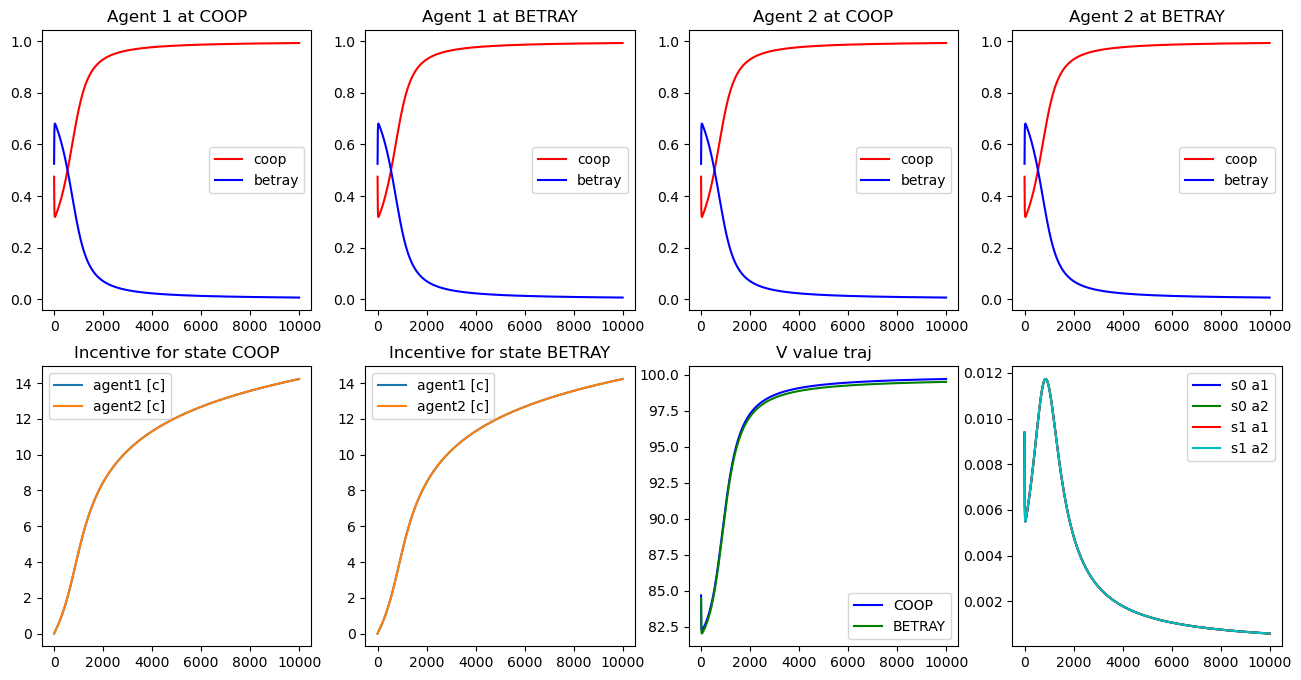

In [54]:
def R0(s, a1, a2):
    assert s==0 or s==1, "The input s is {}, which is neighter 0 nor 1".format(s)
    if s==0:
        reward = 1    # COOP
    elif s==1:
        reward = 0.8    # BETRAY
    return reward

lamda = 2.5
theta_max=100
theta_min=-100
T = 10000
lr_a = 5e-2
lr_i = 5e-1
gamma = 0.99

a1 = np.array([[0.5,0.5],[0.5,0.5]])
a2 = np.array([[0.5,0.5],[0.5,0.5]])
ID_policy = np.zeros([2,2])   # Initial incentive is set to zero

# Record trajector
a1_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
a2_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
incentive_traj = np.zeros([ T, 2, 2 ])   # [n_iter, n_state, n_actions ]
V_vec_traj = np.zeros([ T, 2 ])
update_term_traj = np.zeros( [T, 2, 2] )

for t in trange(T):
    incentive = np.zeros([2,2,2]) # [n_state, n_agent, n_agent_actions]
    for s in [0,1]: # Note that incentive only directly impact agents' cooperate action
        incentive[s, 0, 0] = ID_policy[s, 0]    # agent 1
        incentive[s, 1, 0] = ID_policy[s, 1]    # agent 2

    # Update agents strategies and incentive policy
    for s in [0,1]:
        a1[s], a2[s] = update_strategies(s, a1[s], a2[s], incentive[s][0], incentive[s][1], lamda, lr_a)

    # calculate the V value function
    R_vec = np.zeros(2)
    for s in [0,1]:
        R_vec[s] = R0(s, a1[s], a2[s])
    P_mat = get_P_mat(a1, a2)
    V_vec = np.linalg.inv(np.eye(2) - gamma*P_mat) @ R_vec
    V_vec_traj[t] = V_vec

    # Calculate nabla_a Q(s,a)
    nabla_a_Q = np.zeros([2, 4])
    nabla_a_P = np.array( [ [[a2[0][0], 0, a1[0][0], 0],     # nabla_a P(COOP|COOP,a)
                             [a2[0][1], 1, a1[0][1], 1]],     # nabla_a P(BETRAY|COOP,a)
                            [[a2[1][0], 0, a1[1][0], 0],     # nabla_a P(COOP|BETRAY,a)
                             [a2[1][1], 1, a1[1][1], 1]]] )   # nabla_a P(BETRAY|BETRAY,a)
    for s in [0,1]:
        nabla_a_Q[s] = gamma * ( nabla_a_P[s][0] * V_vec[0] + nabla_a_P[s][1] * V_vec[1] )
    
    # Calculate the sensitivity matrix
    sensitivity_mat = np.zeros([2, 2, 4])   # n_state, n_theta, n_action
    for s in [0,1]:
        sensitivity_mat[s] = get_sensetivity_mat(s, a1[s], a2[s], lamda)

    # Calculate update term of incentive
    for s in [0,1]:
        update_term = nabla_a_Q[s] @ sensitivity_mat[s].T
        ID_policy[s][0] = np.minimum(theta_max, np.maximum( theta_min, ID_policy[s][0]+lr_i * update_term[0]))
        ID_policy[s][1] = np.minimum(theta_max, np.maximum( theta_min, ID_policy[s][1]+lr_i * update_term[1]))
        update_term_traj[t, s] = update_term

    # Record trajectory
    for s in [0,1]:
        a1_traj[t, s] = a1[s]
        a2_traj[t, s] = a2[s]
        incentive_traj[t, s] = ID_policy[s]

plot_mdp(T=T, a1_traj=a1_traj, a2_traj=a2_traj, incentive_traj=incentive_traj, V_vec_traj=V_vec_traj, update_term_traj=update_term_traj)

## Result for reward_type 1
The reward type=1 is 
$$
\begin{align}
\bar{R}_{\text{COOP}} (a^1_C, a^2_C) &= (a^1_C[\mathbf{c}] + a^2_C[\mathbf{c}])*2\\
\bar{R}_{\text{BETRAY}}(a^1_B, a^2_B) &= a^1_B[\mathbf{b}]+a^2_B[\mathbf{b}]
\end{align}
$$
The problem is slightly harder than previous one, since at state `BETRAY`, in the sense of immediate reward, the optimal action will be stay at `BETRAY`. However, only in a long run, move to state `COOP` can obtain more reward.  

The first stage calculated reward is:  

100%|██████████| 1000/1000 [00:00<00:00, 5499.52it/s]


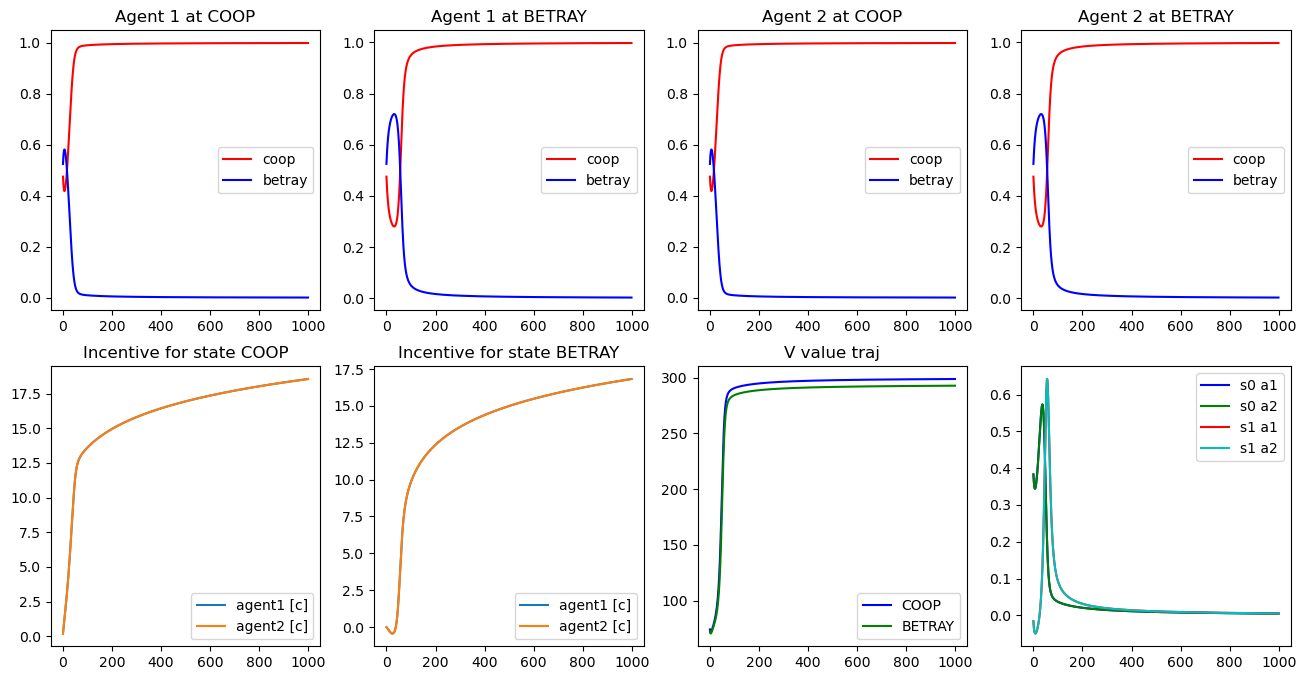

In [56]:
coef = 3
def R1(s, a1, a2):
    assert s==0 or s==1, "The input s is {}, which is neighter 0 nor 1".format(s)
    if s==0:
        reward = coef*(a1[0]+a2[0])    # COOP
    elif s==1:
        reward = a1[1]+a2[1]    # BETRAY
    return reward

lamda = 2.5
theta_max=100
theta_min=-100
T = 1000
lr_a = 5e-2
lr_i = 5e-1
gamma = 0.98

a1 = np.array([[0.5,0.5],[0.5,0.5]])
a2 = np.array([[0.5,0.5],[0.5,0.5]])
ID_policy = np.zeros([2,2])   # Initial incentive is set to zero

# Record trajector
a1_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
a2_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
incentive_traj = np.zeros([ T, 2, 2 ])   # [n_iter, n_state, n_actions ]
V_vec_traj = np.zeros( [T, 2] ) # [n_iter, n_state]
update_term_traj = np.zeros( [T, 2, 2] )    # [n_iter, n_state, n_actions]

for t in trange(T):
    incentive = np.zeros([2,2,2]) # [n_state, n_agent, n_agent_actions]
    for s in [0,1]: # Note that incentive only directly impact agents' cooperate action
        incentive[s, 0, 0] = ID_policy[s, 0]    # agent 1
        incentive[s, 1, 0] = ID_policy[s, 1]    # agent 2

    # Update agents strategies and incentive policy
    for s in [0,1]:
        a1[s], a2[s] = update_strategies(s, a1[s], a2[s], incentive[s][0], incentive[s][1], lamda, lr_a)

    # calculate the V value function
    R_vec = np.zeros(2)
    for s in [0,1]:
        R_vec[s] = R1(s, a1[s], a2[s])
    P_mat = get_P_mat(a1, a2)
    V_vec = np.linalg.inv(np.eye(2) - gamma*P_mat) @ R_vec
    V_vec_traj[t] = V_vec

    # Calculate nabla_a Q(s,a)
    nabla_a_Q = np.zeros([2, 4])
    nabla_a_P = np.array( [ [[a2[0][0], 0, a1[0][0], 0],     # nabla_a P(COOP|COOP,a)
                             [a2[0][1], 1, a1[0][1], 1]],     # nabla_a P(BETRAY|COOP,a)
                            [[a2[1][0], 0, a1[1][0], 0],     # nabla_a P(COOP|BETRAY,a)
                             [a2[1][1], 1, a1[1][1], 1]]] )   # nabla_a P(BETRAY|BETRAY,a)
    nabla_a_Q[0] = np.array([coef, 0, coef, 0]) + gamma * ( nabla_a_P[0][0] * V_vec[0] + nabla_a_P[0][1] * V_vec[1] ) # nabla_a_R + \gamma * \sum_{s'\in S} nabla_a_P * V(s')
    nabla_a_Q[1] = np.array([0, 1, 0, 1]) + gamma * ( nabla_a_P[1][0] * V_vec[0] + nabla_a_P[1][1] * V_vec[1] ) # nabla_a_R + \gamma * \sum_{s'\in S} nabla_a_P * V(s')
    
    # Calculate the sensitivity matrix
    sensitivity_mat = np.zeros([2, 2, 4])   # n_state, n_theta, n_action
    for s in [0,1]:
        sensitivity_mat[s] = get_sensetivity_mat(s, a1[s], a2[s], lamda)

    # Calculate update term of incentive
    for s in [0,1]:
        update_term = nabla_a_Q[s] @ sensitivity_mat[s].T
        ID_policy[s][0] = np.minimum(theta_max, np.maximum( theta_min, ID_policy[s][0]+lr_i * update_term[0]))
        ID_policy[s][1] = np.minimum(theta_max, np.maximum( theta_min, ID_policy[s][1]+lr_i * update_term[1]))
        update_term_traj[t][s] = update_term

    # Record trajectory

    for s in [0,1]:
        a1_traj[t, s] = a1[s]
        a2_traj[t, s] = a2[s]
        incentive_traj[t, s] = ID_policy[s]

plot_mdp(T=T, a1_traj=a1_traj, a2_traj=a2_traj, incentive_traj=incentive_traj, V_vec_traj=V_vec_traj, update_term_traj=update_term_traj)

## Result for reward_type 2
We then test for reward type=2:
$$
\begin{align}
\bar{R}_{\text{COOP}}(a^1_C, a^2_C) &= 2.5 - \left((a^1_C[\mathbf{c}]-0.7)^2 + (a^2_C[\mathbf{c}]-0.85)^2\right) \\
\bar{R}_\text{BETRAY} (a^1_B, a^2_B) &= 2. - \left((a^1_B[\mathbf{b}]-0.85)^2 + (a^2_B[\mathbf{b}]-0.85)^2\right)
\end{align}
$$ 
This reward type is harder than previous one since it requires agents' strategies to be at middle, rather than in two extreme.

100%|██████████| 2000/2000 [00:00<00:00, 5762.51it/s]


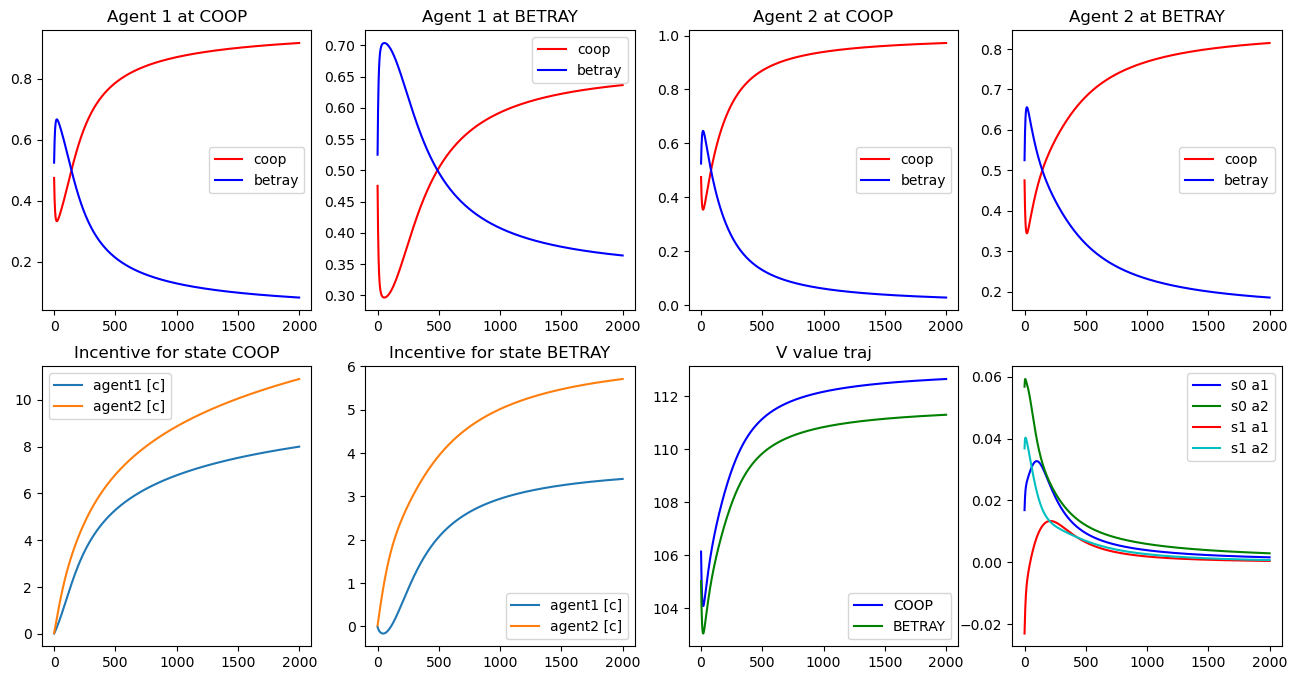

In [66]:
COOP_VAL = [0.3, 0.5]
BETRAY_VAL = [0.9, 0.6]

def R2(s, a1, a2):
    assert s==0 or s==1, "The input s is {}, which is neighter 0 nor 1".format(s)
    if s==0:
        reward = 3.0 - (a1[0]-COOP_VAL[0])**2 - (a2[0]-COOP_VAL[1])**2    # COOP
    elif s==1:
        reward = 2. - (a1[1]-BETRAY_VAL[0])**2 - (a2[1]-BETRAY_VAL[1])**2   # BETRAY
    return reward

lamda = 2.5
theta_max=100
theta_min=-100
T = 2000
lr_a = 5e-2
lr_i = 5e-1
gamma = 0.98

a1 = np.array([[0.5,0.5],[0.5,0.5]])
a2 = np.array([[0.5,0.5],[0.5,0.5]])
ID_policy = np.zeros([2,2])   # Initial incentive is set to zero

# Record trajector
a1_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
a2_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
incentive_traj = np.zeros([ T, 2, 2 ])   # [n_iter, n_state, n_actions ]
V_vec_traj = np.zeros([T, 2])   # [n_iter, n_state]
update_term_traj = np.zeros( [T, 2, 2] )    # [n_iter, n_state, n_actions]

for t in trange(T):
    incentive = np.zeros([2,2,2]) # [n_state, n_agent, n_agent_actions]
    for s in [0,1]: # Note that incentive only directly impact agents' cooperate action
        incentive[s, 0, 0] = ID_policy[s, 0]    # agent 1
        incentive[s, 1, 0] = ID_policy[s, 1]    # agent 2

    # Update agents strategies and incentive policy
    for s in [0,1]:
        a1[s], a2[s] = update_strategies(s, a1[s], a2[s], incentive[s][0], incentive[s][1], lamda, lr_a)

    # calculate the V value function
    R_vec = np.zeros(2)
    for s in [0,1]:
        R_vec[s] = R2(s, a1[s], a2[s])
    P_mat = get_P_mat(a1, a2)
    V_vec = np.linalg.inv(np.eye(2) - gamma*P_mat) @ R_vec
    V_vec_traj[t] = V_vec

    # Calculate nabla_a Q(s,a)
    nabla_a_Q = np.zeros([2, 4])
    nabla_a_P = np.array( [ [[a2[0][0], 0, a1[0][0], 0],     # nabla_a P(COOP|COOP,a)
                             [a2[0][1], 1, a1[0][1], 1]],     # nabla_a P(BETRAY|COOP,a)
                            [[a2[1][0], 0, a1[1][0], 0],     # nabla_a P(COOP|BETRAY,a)
                             [a2[1][1], 1, a1[1][1], 1]]] )   # nabla_a P(BETRAY|BETRAY,a)
    # nabla_a_R = np.array( [  ] )
    nabla_a_Q[0] = np.array([-2*(a1[0][0]-COOP_VAL[0]), 0, -2*(a2[0][0]-COOP_VAL[1]), 0]) + gamma * ( nabla_a_P[0][0] * V_vec[0] + nabla_a_P[0][1] * V_vec[1] ) # nabla_a_R + \gamma * \sum_{s'\in S} nabla_a_P * V(s')
    nabla_a_Q[1] = np.array([0, -2*(a1[1][1]-BETRAY_VAL[0]), 0, -2*(a2[1][1]-BETRAY_VAL[1])]) + gamma * ( nabla_a_P[1][0] * V_vec[0] + nabla_a_P[1][1] * V_vec[1] ) # nabla_a_R + \gamma * \sum_{s'\in S} nabla_a_P * V(s')
    
    # Calculate the sensitivity matrix
    sensitivity_mat = np.zeros([2, 2, 4])   # n_state, n_theta, n_action
    for s in [0,1]:
        sensitivity_mat[s] = get_sensetivity_mat(s, a1[s], a2[s], lamda)

    # Calculate update term of incentive
    for s in [0,1]:
        update_term = nabla_a_Q[s] @ sensitivity_mat[s].T
        ID_policy[s][0] = np.minimum(theta_max, np.maximum( theta_min, ID_policy[s][0]+lr_i * update_term[0]))
        ID_policy[s][1] = np.minimum(theta_max, np.maximum( theta_min, ID_policy[s][1]+lr_i * update_term[1]))
        update_term_traj[t][s] = update_term

    # Record trajectory
    for s in [0,1]:
        a1_traj[t, s] = a1[s]
        a2_traj[t, s] = a2[s]
        incentive_traj[t, s] = ID_policy[s]

plot_mdp(T=T, a1_traj=a1_traj, a2_traj=a2_traj, incentive_traj=incentive_traj, V_vec_traj=V_vec_traj, update_term_traj=update_term_traj)